In [1]:
import numpy as np
import tensorflow as tf
import os,shutil
import numpy as np
import cv2
import pickle
import pandas as pd

from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Dropout, Activation
from keras.initializers import glorot_normal
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import binary_crossentropy
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
cur_dir = os.getcwd()

dataset_dir = os.path.join(cur_dir,"Dataset")

labels_dir = os.path.join(dataset_dir,"labels")
frames_dir = os.path.join(dataset_dir,"frames")

n_lecs = len(os.listdir(labels_dir))

listOfLectures = []

for lec in sorted(os.listdir(frames_dir)):
    if lec.startswith('.'):
        continue
    frame_list = []
    lec_path = os.path.join(frames_dir,lec)
    for frame in sorted(os.listdir(lec_path)):
        frame_list.append([os.path.join(lec_path,frame),])
    listOfLectures.append(frame_list)


lec_num = 0
for csv in sorted(os.listdir(labels_dir)):
    csv_path = os.path.join(labels_dir,csv)
    with open(csv_path,'r') as input:
        data = input.read()
        data = data.split()
        for i in range(len(data)):
            listOfLectures[lec_num][i].append(int(data[i]))
    lec_num+=1

Window size is the size of window on either side. Using window_size = 2 will cause 5 frames to be stacked for one input example

In [4]:
def load_data_fast(listOfLectures, resolution, window_size):
    X_train = []
    Y_train = []
    for i in tqdm_notebook(range(len(listOfLectures))):
        im_saved = []
        for j in tqdm_notebook(range(window_size,len(listOfLectures[i])-window_size)):
            if j == window_size:
                im_saved = [cv2.resize(cv2.imread(listOfLectures[i][j+k][0], 0), resolution)
                       for k in range(-window_size, window_size+1)]
            else:
                ims = im_saved[1:]
                ims.append(cv2.resize(cv2.imread(listOfLectures[i][j+window_size][0], 0), resolution))
                im_saved = ims
            x = np.hstack(im_saved)
            x = x[:,:,np.newaxis]
            X_train.append(x)
            Y_train.append(listOfLectures[i][j][1])
    return X_train, Y_train

In [45]:
resolution = (60,80)
window_size = 1
X_train, Y_train = load_data_fast(listOfLectures, resolution, window_size)

In [43]:
print(X_train[0].shape)
qwe = X_train[0][:, :, np.newaxis]
print(qwe.shape)
print(len(X_train))

(80, 180)
(80, 180, 1)
26160


In [46]:
X_train = np.stack(X_train)
print(X_train.shape)

(29067, 80, 180, 1)


Run the code below only if you change the architecture

In [47]:
with open("./XY_train_80_60_3_horizontal_stack.pkl", "wb") as pickle_in:
    pickle.dump((X_train, Y_train), pickle_in)

In [48]:
with open("./XY_train_80_60_3_horizontal_stack.pkl", "rb") as pickle_in:
    X_train, Y_train = pickle.load(pickle_in)

In [49]:
Y_train = to_categorical(Y_train)

In [51]:
print(Y_train.shape)
print(X_train.shape)

(26160, 2)
(26160, 80, 180, 1)


In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=42, stratify=Y_train)

In [52]:
print(X_train.shape)
print(X_test.shape)

(26160, 80, 180, 1)
(2907, 80, 180, 1)


In [53]:
n_zeros_train = np.sum(Y_train[:, 0])    # no. of 0s in Y_train
n_ones_train = np.sum(Y_train[:, 1])    # no. of 1s in Y_train

In [5]:
n_zeros_train

NameError: name 'n_zeros_train' is not defined

In [54]:
from sklearn.utils import resample
scale_ones_to_zeros = 0.5
X_train_pos = X_train[Y_train[:, 1] == 1]
Y_train_pos = Y_train[Y_train[:, 1] == 1]
X_train_ups, Y_train_ups =  resample(X_train_pos, Y_train_pos, 
                                 replace=True,     # sample with replacement
                                 n_samples=int(n_zeros_train*scale_ones_to_zeros),    # to match majority class
                                 random_state=123)

In [55]:
X_train_final = np.concatenate((X_train[Y_train[:, 1] == 0], X_train_ups), axis=0)
Y_train_final = np.concatenate((Y_train[Y_train[:, 1] == 0], Y_train_ups), axis=0)

In [56]:
print(X_train_final.shape)
print(Y_train_final.shape)

(37762, 80, 180, 1)
(37762, 2)


In [57]:
num_epochs = 5
num_classes = 2
# batch_size = 100
learning_rate = 0.001

In [69]:
def gen_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape= (80,180,1), padding='valid'))
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='valid'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
    
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
    
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    return model

In [70]:
model = gen_model()

In [71]:
optim = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=True)

In [72]:
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

In [73]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit(X_train_final, Y_train_final, epochs=num_epochs, verbose=1, validation_data=(X_test, Y_test), callbacks=[es])

Train on 37762 samples, validate on 2907 samples
Epoch 1/5
37762/37762 [==============================] - 118s 3ms/step - loss: 0.6376 - acc: 0.8159 - val_loss: 1.2792 - val_acc: 0.7650
Epoch 2/5
37762/37762 [==============================] - 117s 3ms/step - loss: 0.3400 - acc: 0.8955 - val_loss: 0.2076 - val_acc: 0.9436
Epoch 3/5
26944/37762 [====================>.........] - ETA: 32s - loss: 0.2321 - acc: 0.9259

In [ ]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=1)
_, test_acc = model.evaluate(X_test, Y_test, verbose=1)

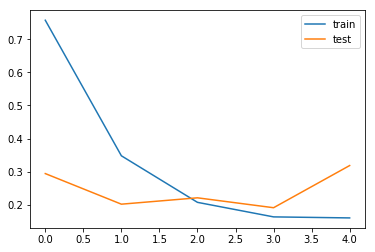

In [65]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [63]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)

In [41]:
print(classification_report(np.argmax(Y_test, axis=1), preds))
print(f1_score(np.argmax(Y_test, axis=1), preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2798
           1       0.84      0.86      0.85       109

   micro avg       0.99      0.99      0.99      2907
   macro avg       0.92      0.93      0.92      2907
weighted avg       0.99      0.99      0.99      2907

0.8506787330316743


In [116]:
model.save('f1_0.8.h5')

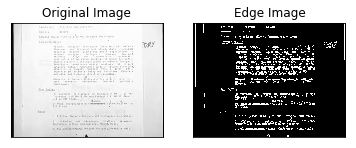

In [43]:
im = cv2.imread(listOfLectures[0][1][0],0)
hog = cv2.HOGDescriptor()
h = hog.compute(im)
plt.subplot(121),plt.imshow(im,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()